In [3039]:
%matplotlib inline
import re
import pandas as pd
import requests
import numpy as np
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import plotly as py
import seaborn as sbn
import textatistic
from bs4 import BeautifulSoup
matplotlib.style.use('ggplot')
import psycopg2
py.offline.init_notebook_mode()

In [3040]:
all_courses = requests.get('https://www.luther.edu/catalog/curriculum')

In [3041]:
soup = BeautifulSoup(all_courses.text, 'html.parser')

In [3042]:
dept_list = soup.select('ul.childrenList a')
major_list = []
for item in dept_list:
    dept = item.get('href', 'None')
    if dept != 'None':
        major_list.append(dept)


In [3043]:
df = pd.DataFrame(columns=['Dept', 'CourseName', 'CourseNumber', 'Hours', 'GenEds', 'Prereqs', 'Description'])

In [3044]:
websites =[]
for item in major_list:
    x = 'https://www.luther.edu/catalog/curriculum/{}'.format(item)
    websites.append(x)


In [3045]:
def find_classes(cup_of_soup,row):
    department = cup_of_soup.find_all('h1', class_='pageTitle')[0].text
    courses = cup_of_soup.find_all('div', class_='courseContainer')
    for item in courses:
        course_title = item.find_all('span', class_='courseTitle')[0].text
        course_number = item.find_all('span', class_='courseNumber')[0].text
        credit_hours = item.find_all('li')[0].text
        for part in item.find_all('li'):
            if part.find_all('i', class_='fa-li fa fa-book fa-lg') != []:
                prereqs = part.text.split(' ')[1:]
                prereqs = ' '.join(prereqs)
            else:
                prereqs = ''
        description = item.find_all('span', class_='courseDescription')[0].text
        geneds = []
        for content in item.find_all('span', class_='genEd'):
            geneds.append(content.text)
        gened_string = ', '.join(geneds)
        df.loc[row] = [department, course_title, course_number, credit_hours, gened_string, prereqs, description]
        row += 1
    return row

In [3046]:
row = 0
for item in major_list:
    this_course = requests.get('https://www.luther.edu/catalog/curriculum/{}'.format(item))
    soup = BeautifulSoup(this_course.text, 'html.parser')
    row = find_classes(soup, row)

In [3047]:
df

Dept  \
0                  Accounting   
1                  Accounting   
2                  Accounting   
3                  Accounting   
4                  Accounting   
5                  Accounting   
6                  Accounting   
7                  Accounting   
8                  Accounting   
9                  Accounting   
10                 Accounting   
11                 Accounting   
12           Africana Studies   
13           Africana Studies   
14           Africana Studies   
15           Africana Studies   
16           Africana Studies   
17           Africana Studies   
18           Africana Studies   
19           Africana Studies   
20           Africana Studies   
21           Africana Studies   
22           Africana Studies   
23           Africana Studies   
24           Africana Studies   
25           Africana Studies   
26           Africana Studies   
27           Africana Studies   
28               Anthropology   
29               Anthropology   
..                        ...   
902                   Theatre   
903                   Theatre   
904                   Theatre   
905  Women and Gender Studies   
906  Women and Gender Studies   
907  Women and Gender Studies   
908  Women and Gender Studies   
909  Women and Gender Studies   
910  Women and Gender Studies   
911  Women and Gender Studies   
912  Women and Gender Studies   
913  Women and Gender Studies   
914  Women and Gender Studies   
915  Women and Gender Studies   
916  Women and Gender Studies   
917  Women and Gender Studies   
918  Women and Gender Studies   
919  Women and Gender Studies   
920  Women and Gender Studies   
921  Women and Gender Studies   
922  Women and Gender Studies   
923  Women and Gender Studies   
924  Women and Gender Studies   
925  Women and Gender Studies   
926  Women and Gender Studies   
927  Women and Gender Studies   
928  Women and Gender Studies   
929  Women and Gender Studies   
930  Women and Gender Studies   
931  Women and Gender Studies   

                                            CourseName CourseNumber  \
0                           Introduction to Accounting    ACCTG 110   
1                           Fundamentals of Accounting    ACCTG 150   
2                         Managerial Cost Accounting I    ACCTG 250   
3                            Intermediate Accounting I    ACCTG 353   
4                           Intermediate Accounting II    ACCTG 354   
5     Accounting for Government and Nonprofit Entities    ACCTG 357   
6                        Managerial Cost Accounting II    ACCTG 358   
7                                  Advanced Accounting    ACCTG 365   
8                      Auditing and Assurance Services    ACCTG 467   
9                              Federal Income Taxation    ACCTG 468   
10                                             Seminar    ACCTG 485   
11                                      Senior Project    ACCTG 490   
12                            African-American History     AFRS 135   
13                   Literature of the African Peoples     AFRS 147   
14                           History of Africa to 1880     AFRS 171   
15                            History of Modern Africa     AFRS 172   
16   Anthropology in East Africa: Forces of Culture...     AFRS 221   
17                           The Civil Rights Movement     AFRS 235   
18                            Africana Women's Writing     AFRS 240   
19                                     History of Jazz     AFRS 247   
20                         African-American Literature     AFRS 251   
21                                    African Diaspora     AFRS 271   
22                  Topics in African American History     AFRS 331   
23                Constructs of Race and Racialization     AFRS 345   
24                           Topics in African History     AFRS 371   
25                          Topics in Africana History     AFRS 391   
26                               Junior/Senior Seminar     AF

In [3048]:
new_list = []
alist = []
import re
for item in df.Prereqs:
    new_list.append(re.findall(r'[A-Z][A-Z][A-Z]+', item))
for item in new_list:
    alist.append(item)
    
new_df = pd.DataFrame(columns= ['abbv', 'relations'])

new_df['abbv'] = df.CourseNumber.map(lambda x : x.split(' ')[0])

new_df['relations'] = alist

In [3049]:
s = new_df.relations.apply(pd.Series).stack().reset_index(level =1, drop=True)

s.name = 'relation'

new_df = new_df.drop('relations', axis=1).join(s)

new_df = new_df.reset_index(drop = True)

new_df = new_df.drop_duplicates()

new_df = new_df.reset_index(drop = True)

new_df = new_df.dropna(how='any')

new_df = new_df.reset_index(drop = True)

In [3050]:
#df.to_csv('allCourses.csv', index=False)

In [3051]:
#GRAPH WITH ONLY PRE-REQS DIRECTING TO ITS COURSE.
g = nx.DiGraph()
g.add_nodes_from(new_df.abbv)

for index, row in new_df.iterrows():
    g.add_edge(row['abbv'], row['relation'])

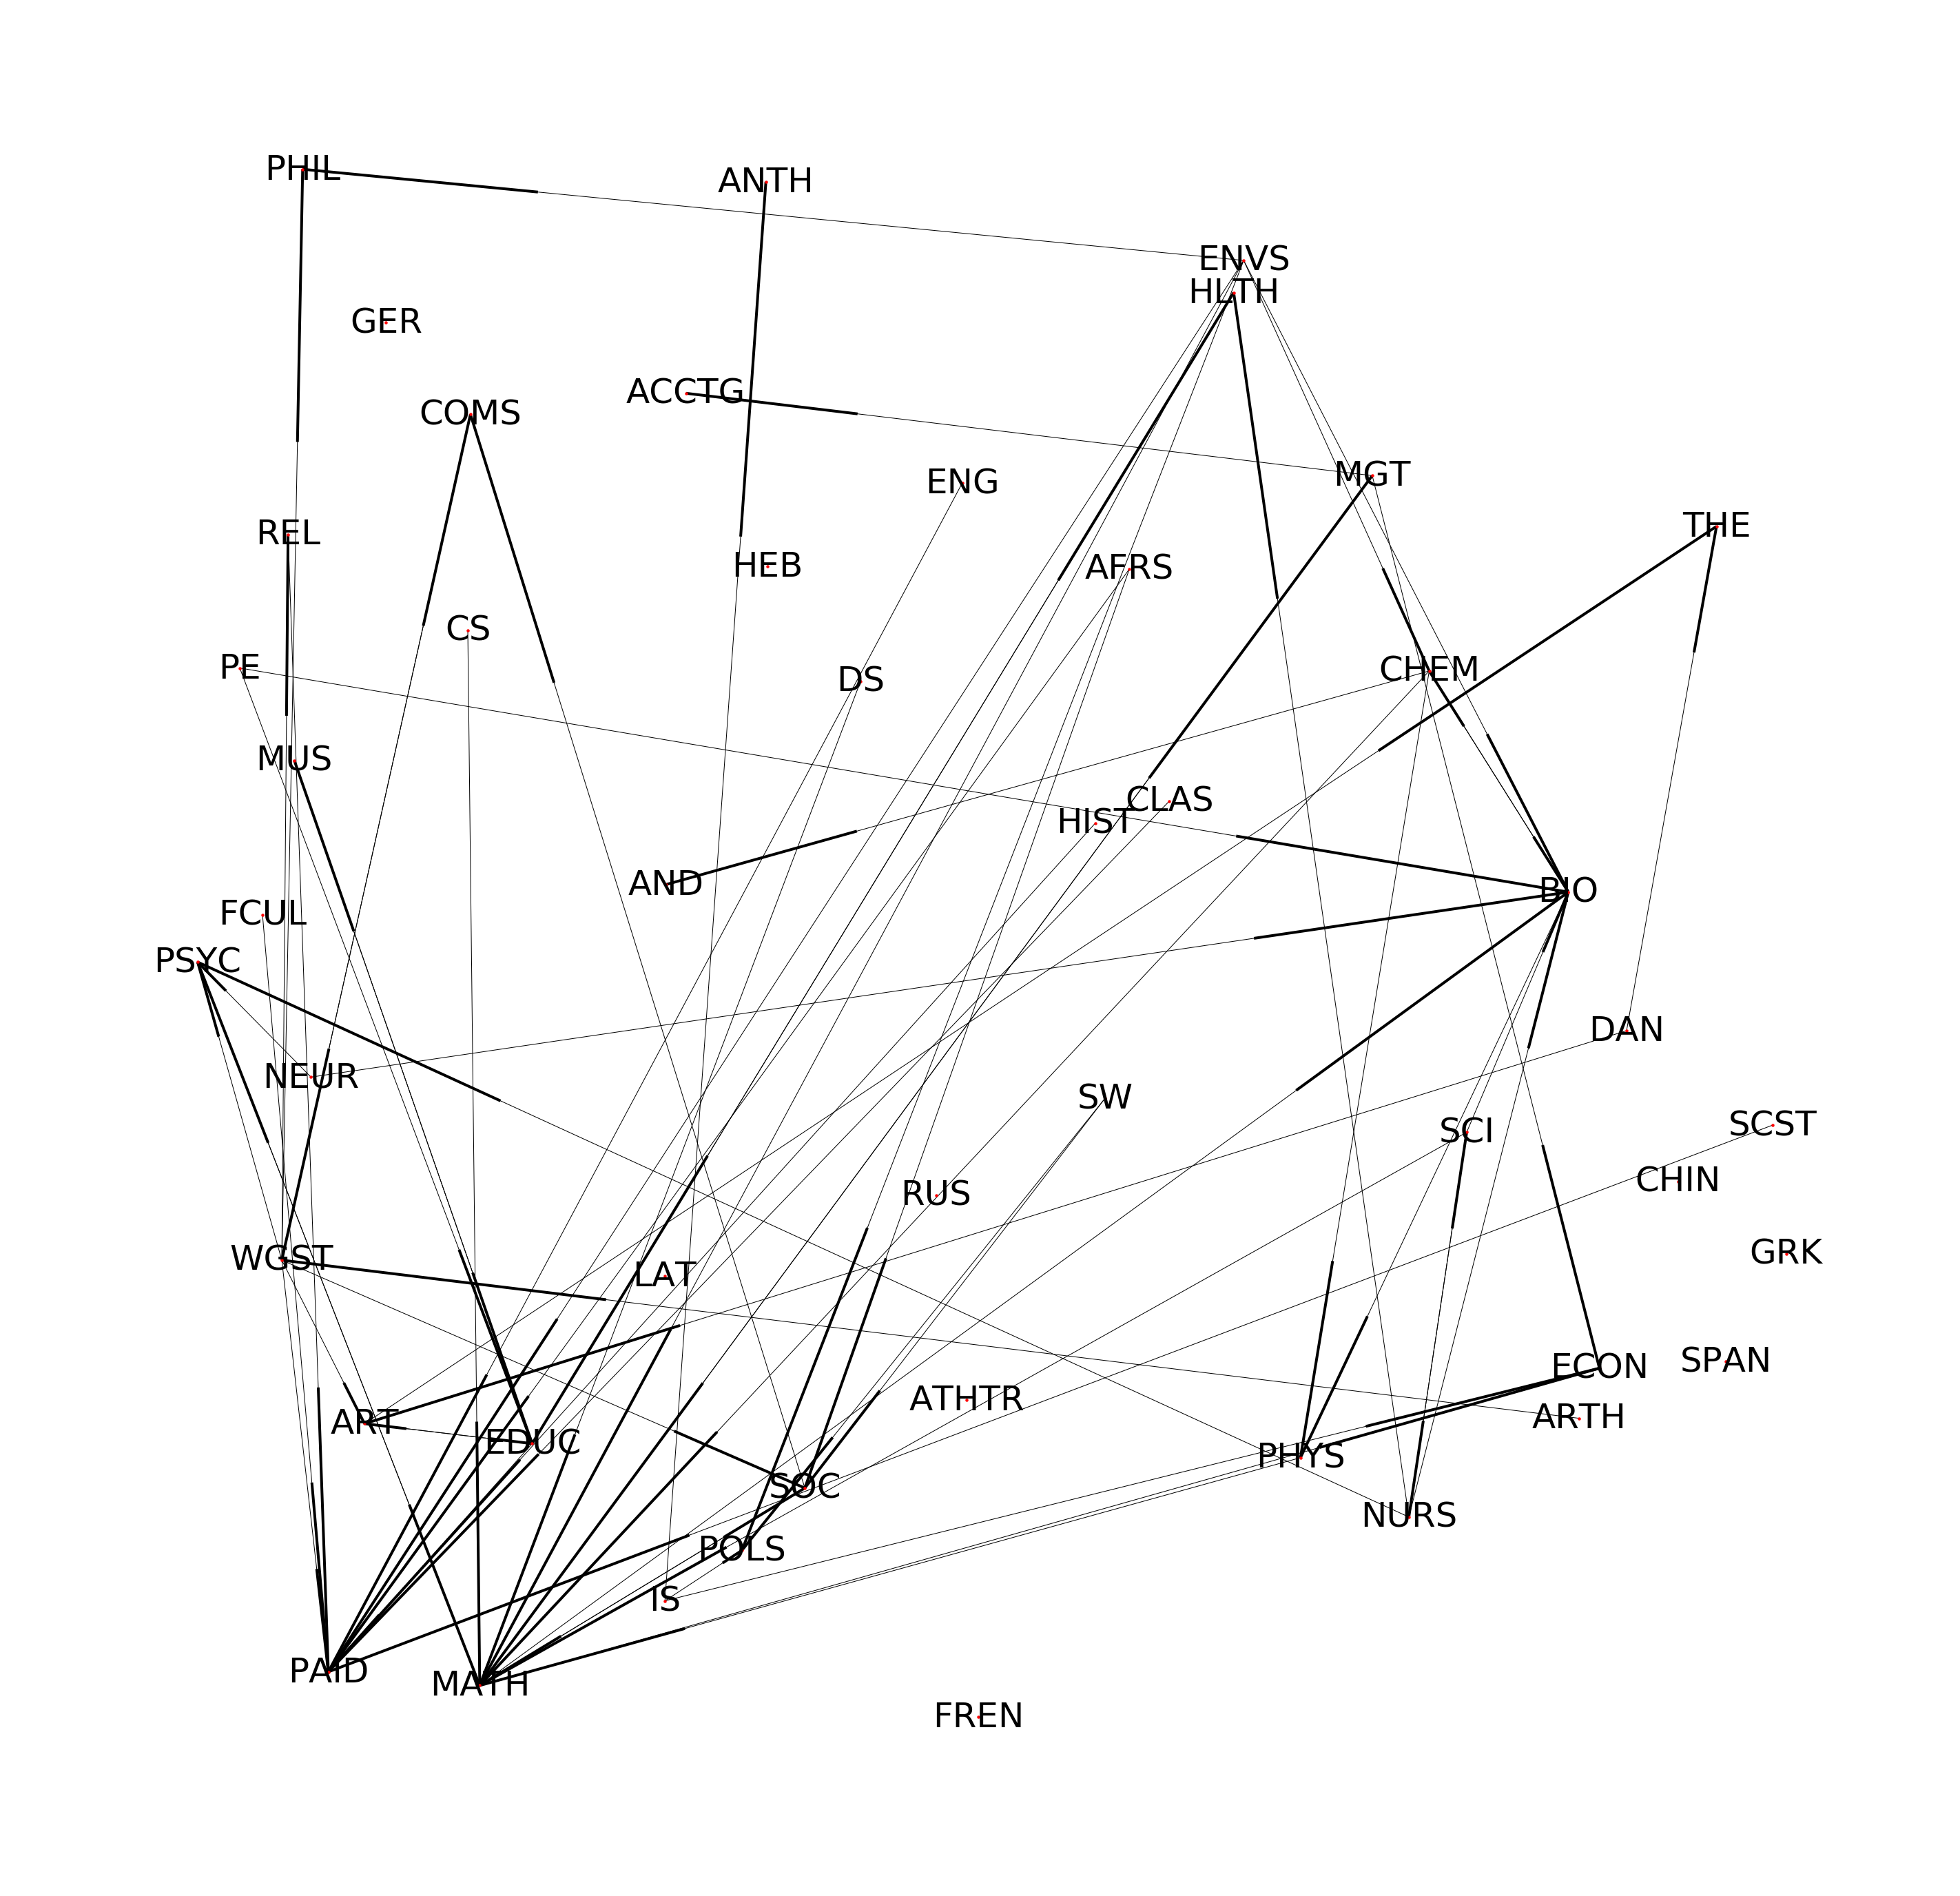

In [3052]:
gfig, gax = plt.subplots(figsize = (50,50))
nx.draw(g,nx.spring_layout(g, k=0.4, iterations = 1), ax=gax, with_labels = True, font_size = 50, node_size = 15)

In [3053]:
try:
    for item in major_list:
        this_course = requests.get('https://www.luther.edu/catalog/curriculum/{}'.format(item))
        soup = BeautifulSoup(this_course.text, 'html.parser')
        list3 = []
        if soup.find_all('h1', class_='pageTitle')[0].text != 'Nordic Studies' and soup.find_all('h1', class_='pageTitle')[0].text != 'Library and Information Studies' and soup.find_all('h1', class_='pageTitle')[0].text != 'Biblical Languages' and soup.find_all('h1', class_='pageTitle')[0].text != 'International Business':
            this = soup.find_all('div', class_='catalog_block')
            #this = soup.find_all('a', name_='block2')
        #FIND BETTER WAY TO ABBV COURSE.
            that = soup.find_all('span', class_='courseNumber')[0].text
        else:
            pass
        for item in this:
            item = item.text
            list3.append(item)
        if len(that) > 1 :
            that = that.split(' ')
        that.pop()
        that = ''.join(that)
        list4 = []
        for item in list3:
            list4.append(re.findall(r'[A-Z][A-Z]+ [0-9]+', item))
        combining = [item for sublist in list4 for item in sublist]
        lst = []
        for item in combining:
            item = item.split(' ')
            lst.append(item)

        for item in lst:
            del item[1]
        lst = [item for sublist in lst for item in sublist]
        lst = set(lst)
        lst = list(lst)
        new_df.set_value(-1, 'abbv', that)
        new_df.set_value(-1, 'relation', lst)
        new_df = new_df.reset_index(drop=True)
except:
    print(item)
    


In [3054]:
s = new_df.relation.apply(pd.Series).stack().reset_index(level = 1, drop=True)

s.name = 'relations'

new_df = new_df.drop('relation', axis=1).join(s)

new_df = new_df.drop_duplicates()

new_df = new_df.sort_values(by=['abbv'])

new_df = new_df.replace('', np.nan, regex=True)

new_df = new_df.replace('^AND', np.nan, regex=True)

new_df = new_df.dropna(how='any')

new_df = new_df.reset_index(drop = True)

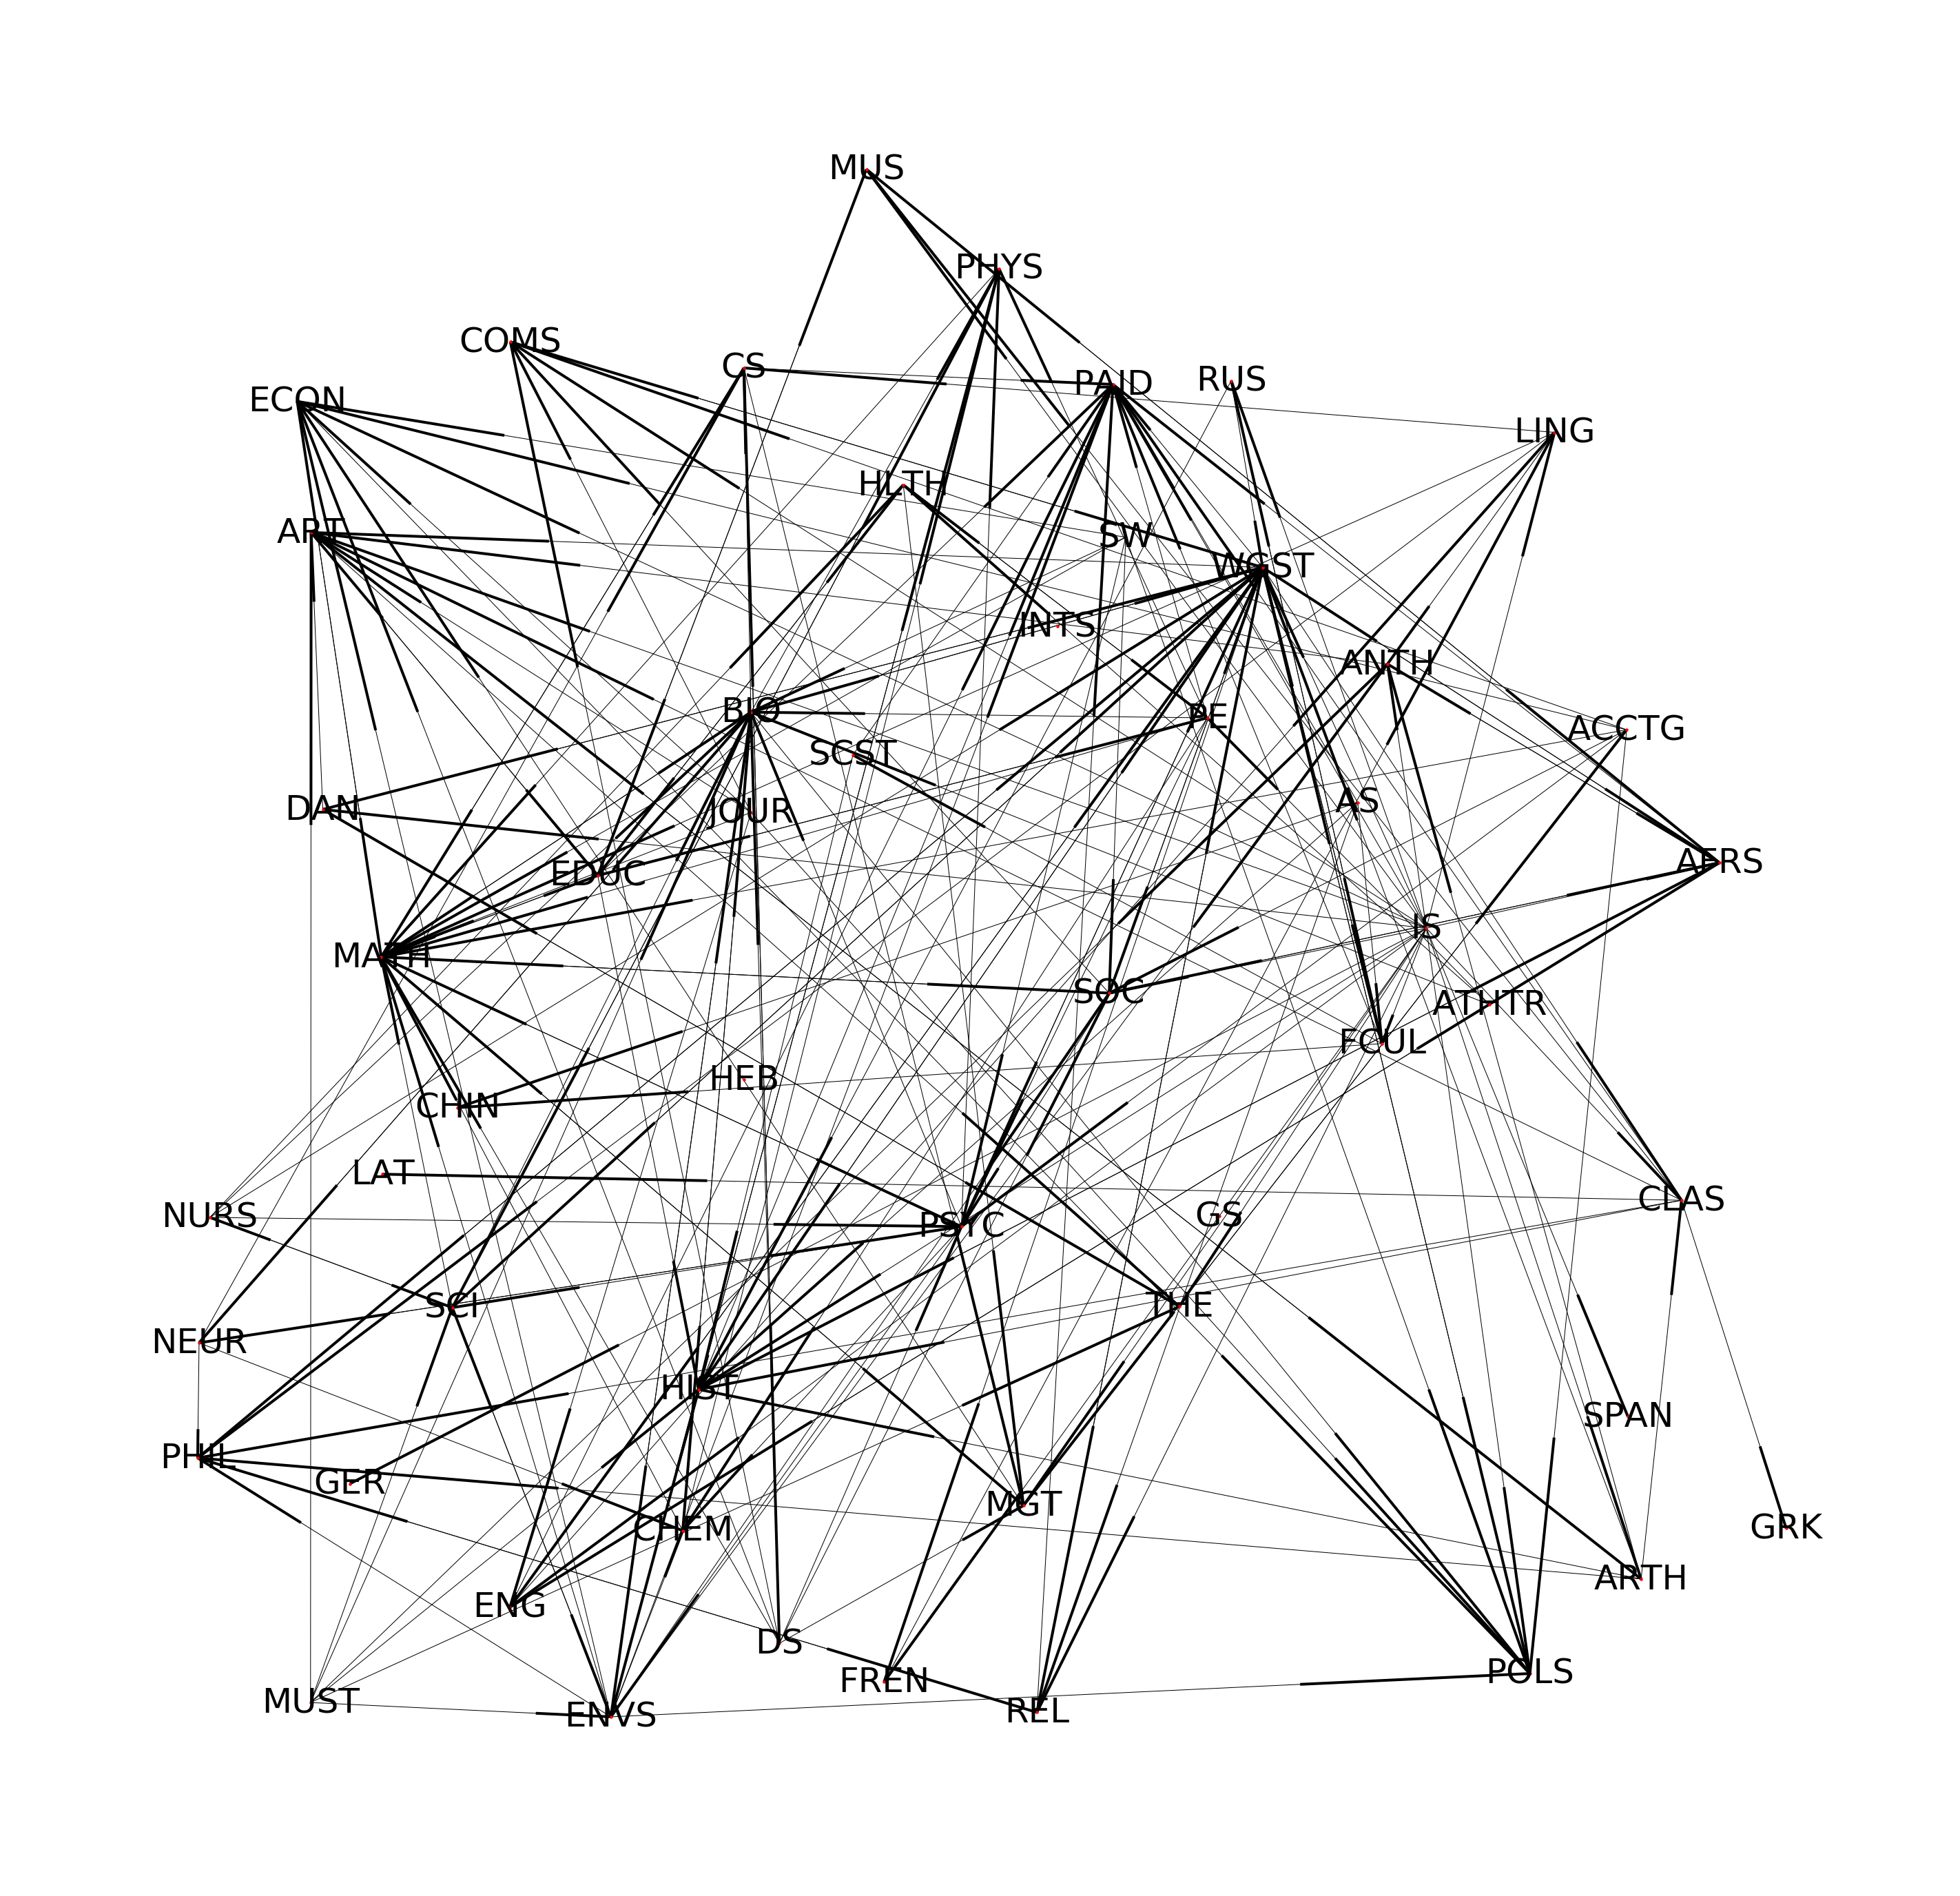

In [3055]:
g = nx.DiGraph()
g.add_nodes_from(new_df.abbv)


for index, row in new_df.iterrows():
    g.add_edge(row['abbv'], row['relations'])
        
gfig, gax = plt.subplots(figsize = (50,50))
nx.draw(g,nx.spring_layout(g, k=0.4, iterations = 1), ax=gax, with_labels = True, font_size = 50, node_size = 15)

## WHICH COURSES ARE THE MOST NON-PREREQ/PRE-REQ IN OTHER COURSES.

In [3067]:
new_df.groupby('relations')['abbv'].count().head()

relations
ACCTG     2
AFRS      8
ANTH      7
ART      10
ARTH      3
Name: abbv, dtype: int64

In [3068]:
new_df.groupby('relations')['abbv'].count() > 10

relations
ACCTG    False
AFRS     False
ANTH     False
ART      False
ARTH     False
AS       False
ATHTR    False
BIO       True
CHEM     False
CHIN     False
CLAS     False
COMS     False
CS       False
DAN      False
DS       False
ECON     False
EDUC     False
ENG      False
ENVS     False
FCUL     False
FREN     False
GER      False
GRK      False
GS       False
HEB      False
HIST      True
HLTH     False
INTS     False
IS       False
JOUR     False
LAT      False
LING     False
MATH      True
MGT      False
MUS      False
MUST     False
NEUR     False
NURS     False
PAID      True
PE       False
PHIL     False
PHYS     False
POLS     False
PSYC     False
REL      False
RUS      False
SCI      False
SCST     False
SOC      False
SPAN     False
SW       False
THE      False
WGST      True
Name: abbv, dtype: bool